# Artists Recommendation System: Combining Neural Collaborative Recommendations and Content Based Recommendations


## Step 1: Import Libraries and Define Constants

In [1]:
%%bash
# Check colab and silent output if there are no errors.
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
# Clone Github repository.
rm -rf artists-recommender
git clone https://github.com/EdenBD/artists-recommender.git

Cloning into 'artists-recommender'...


In [3]:
# Append directories links.
import os

# Data processing and Pytorch.
import pandas as pd
import numpy as np
import torch
import random 

# Data visualization.
import matplotlib.pyplot as plt

# For deterministic results. 
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Keeping track of training time.
from time import time

# Helper functions For plotting.
import sys
sys.path.append('/content/artists-recommender')
from helper import pre_process_df, plot_training, plot_histogram, plot_xygraph, plot_results

#### Notebook Constants

In [4]:

# Split dataset to training, validation and test according to these values.
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1

# Model hyperparameters
N_EPOCHS = 5
BATCH_SIZE = 32 

DROPOUT = 0.3

HIDDEN_DIMS = [512,256,128]
EMBEDDING_DIM = 512

ACCURACY_THRESHOLD = 5

# Number of similar artists to return.
TOP = 5

# Github path.
GIT = '/content/artists-recommender'

# Pre-processed database. 
DB_FILENAME = "filled_ratings.csv"
DB_PATH = os.path.join(GIT, DB_FILENAME)

# trained model.
MODEL_NAME = "artist-recommender.pt"
MODEL_PATH = os.path.join(GIT, MODEL_NAME)


## Step 2: Prepare Dataset


I use [Kaggle EMI Music contest dataset](https://www.kaggle.com/c/MusicHackathon/data).
1. There are 50 unique, anonymous artists.
2. There are ~50K users (i.e. reviewers). 
3. The artists features columns have values: {0,1, nan} where 1 represents an attribute that correctly describes the artist according to the reviewer. 
4. Ratings are a numerical value from 0-100 or nan. 

I pre-processed the dataset before hand, mostly to remove nan values. 

In [7]:
# Load dataset.
df = pd.read_csv(DB_PATH, engine='python')
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

# Dataset size.
print('Number of rows: {:,}'.format(df.shape[0]))
print('Number of columns: {:,}\n'.format(df.shape[1]))

# Number of nulls and type of column.
print(df.info())

# Sample two example rows.
df.sample(2)



Number of rows: 33,308
Number of columns: 27

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33308 entries, 0 to 33307
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Artist         33308 non-null  int64  
 1   User           33308 non-null  int64  
 2   LIKE_ARTIST    33308 non-null  float64
 3   Edgy           33308 non-null  int64  
 4   Thoughtful     33308 non-null  int64  
 5   Youthful       32491 non-null  float64
 6   Current        33308 non-null  int64  
 7   Stylish        33308 non-null  int64  
 8   Beautiful      33308 non-null  int64  
 9   Fun            33308 non-null  int64  
 10  Authentic      33308 non-null  int64  
 11  Credible       33308 non-null  int64  
 12  Cool           33308 non-null  int64  
 13  Catchy         32491 non-null  float64
 14  Passionate     33308 non-null  int64  
 15  Timeless       33308 non-null  int64  
 16  Original       33308 non-null  int64  
 17  Tale

,Artist,User,LIKE_ARTIST,Edgy,Thoughtful,Youthful,Current,Stylish,Beautiful,Fun,Authentic,Credible,Cool,Catchy,Passionate,Timeless,Original,Talented,Distinctive,Approachable,Trendsetter,Upbeat,Energetic,None of these,Sexy,Dated,Warm
18440,30,12025,10.0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,1,0,0,0.0,0
9907,43,20585,74.0,0,1,0.0,1,1,1,0,1,1,1,1.0,1,1,0,1,1,1,0,0.0,0,0,0,0.0,1


### Inspect Dataset

In [8]:
# Number of unique artists and users.
n_users = len(df['User'].unique())
n_artists = len(df['Artist'].unique())
print("Number of Unique Users: {:,}".format(n_users))
print("Number of Unique Artists: {}\n".format(n_artists))

# Get list of users, artists and ratings
users = df['User'].values
artists = df['Artist'].values
ratings = df['LIKE_ARTIST'].values



Number of Unique Users: 23,634
Number of Unique Artists: 50



Ratings avg. value: 48.12


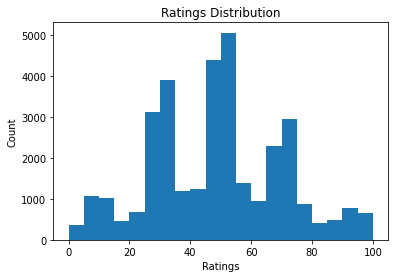

In [10]:
# Ratings histogram.
plot_histogram(df['LIKE_ARTIST'],20,'Ratings','Count','Ratings Distribution')


Minimum number of Ratings per Artist: 34
Maximum number of Ratings per Artist: 3,307



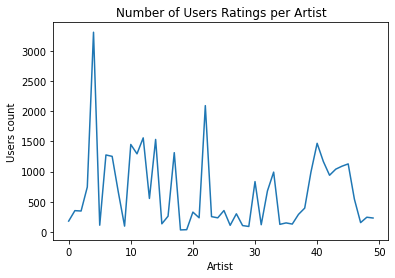

In [11]:
# Users Ratings per Artist.
users_per_artist = df.groupby('Artist').count()['User']
print("Minimum number of Ratings per Artist: {:,}".format(min(users_per_artist)))
print("Maximum number of Ratings per Artist: {:,}\n".format(max(users_per_artist)))
plot_xygraph(users_per_artist,'Number of Users Ratings per Artist','Artist','Users count')
print('\n')

Minimum number of Ratings per User: 1
Maximum number of Ratings per User: 3

Precentage of Users with No Ratings: 0.0% 



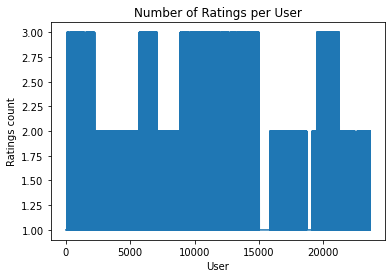

In [13]:
# Ratings per User.
ratings_per_user = df.groupby('User').count()['LIKE_ARTIST']
print("Minimum number of Ratings per User: {:,}".format(min(ratings_per_user)))
print("Maximum number of Ratings per User: {:,}\n".format(max(ratings_per_user)))
# Check all users have at least one rating.
nulls_users = np.count_nonzero(ratings_per_user == 0)
print('Precentage of Users with No Ratings: {:.1f}% \n'.format((nulls_users/len(ratings_per_user))*100))
plot_xygraph(ratings_per_user,'Number of Ratings per User','User','Ratings count')

#### Pytorch Iterator
Split data to Train, Validation, Test and create a Pytorch Iterator.

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Convert the lists into tensors.
users = torch.LongTensor(users)
artists = torch.LongTensor(artists)
ratings = torch.tensor(ratings)

# Combine the inputs into a TensorDataset.
dataset = TensorDataset(users, artists, ratings)

# Split train-validation-test sizes.
train_size = int(TRAIN_SIZE * len(dataset))
val_size = int(VALIDATION_SIZE * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset randomly.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders.
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Select batches randomly.
            batch_size = BATCH_SIZE 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull batches sequentially.
            batch_size = BATCH_SIZE 
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset), # Pull batches sequentially.
            batch_size = BATCH_SIZE 
        )

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))
print('Number of test samples: {:,}'.format(test_size))

Number of training samples: 26,646
Number of validation samples: 3,330
Number of test samples: 3,332


## Step 3: Define the Model


### Neural Collborative Filtering Recommender:

Build a model for the Regression task: **f(user, artist) = Rating**, a numerical value in the range [0-100].

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralArtistRecommender(nn.Module):
  """
  Feedforward model with Embeddings for users and artist.
  
  Args:
    hidden_dims (list): hidden dimensions of linearr layers of the FF model. 
  """
  def __init__(self, n_users, n_artists, embedding_dim, hidden_dims, dropout):

    super().__init__()

    self.user_embedding = nn.Embedding(n_users, embedding_dim) 
    self.artist_embedding = nn.Embedding(n_artists, embedding_dim) 

    self.dropout_probability = dropout
    # A list of linear submodules.
    self.linears = nn.ModuleList([nn.Linear(embedding_dim * 2, hidden_dims[0])])
    self.linears.extend([nn.Linear(hidden_dims[idx], hidden_dims[idx+1]) for idx in range(len(hidden_dims)-1)])

    # Regression task, output 1 numerical value
    self.out = nn.Linear(hidden_dims[-1], 1)

  def forward(self, users, artists):

    # Concatenate user and artist embeddings.
    user_embed = self.user_embedding(users)
    artist_embed = self.artist_embedding(artists)

    hidden = torch.cat([user_embed, artist_embed], dim=1)

    # Add Leaky RELU and dropout to each linear layer.
    for idx in range(len(self.linears)):
        hidden = self.linears[idx](hidden)
        hidden = F.leaky_relu(hidden)
        hidden = F.dropout(hidden,  p=self.dropout_probability)
    
    # Linear activation at output layer
    rating = self.out(hidden)
    
    return rating


In [ ]:
model = NeuralArtistRecommender(n_users, 
                                n_artists, 
                                EMBEDDING_DIM, 
                                HIDDEN_DIMS, 
                                DROPOUT)

In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

user_embedding.weight
artist_embedding.weight
linears.0.weight
linears.0.bias
linears.1.weight
linears.1.bias
linears.2.weight
linears.2.bias
out.weight
out.bias
The model has 12,815,361 trainable parameters


#### Train Neural Model

1. Sample a batch.
2. Compute loss `MSE loss` and accuracy `batch_accuracy`.
3. Compute gradients of trainable weights.
4. Update weights accordingly with optimizer `AdamW`.

Each Epoch takes about 5 minutes to train.

Check if any GPUs are available, and if available, put the model and criterion onto the GPU.

In [ ]:
# If there's a GPU available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('There are {} GPU(s) available. \n'.format(torch.cuda.device_count()))

# Fit model and criterion to Cuda.
model = model.to(device)

# Convert model parameters to double.
model.double()

There are 0 GPU(s) available. 



NeuralArtistRecommender(
  (user_embedding): Embedding(23634, 512)
  (artist_embedding): Embedding(50, 512)
  (linears): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def batch_accuracy(predictions, labels, threshold=ACCURACY_THRESHOLD):
    """
    Args: 
      preds and labels are both (batch_size,). 
      labels are the ratings between [0-100].

    Returns a float between 0-1, represents precentage of correct predictions in batch. 
    A correct a prediction for which abs(prediction-label) <=  threshold.
    """
    # Convert to CPU to be able to use numpy.
    preds = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    # Filter all the correct predictions, corrrect are those close enough to the labels.
    correct_mask = np.isclose(preds, labels, rtol=threshold, atol=threshold)

    return np.sum(correct_mask)

In [ ]:
import torch.optim as optim

# The call to model.parameters() contains the learnable parameters.
optimizer = optim.AdamW(model.parameters())
criterion = nn.MSELoss().to(device)
criterion = criterion.to(device)


def train_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()  
    epoch_loss, epoch_acc = 0, 0
    num_samples = len(train_loader.dataset)
    
    # 1) Get a batch.
    for batch_idx, (users, artists, targets) in enumerate(train_loader):  
       
        optimizer.zero_grad()

        # Compute batch predictions. 
        users = users.to(device)
        artists = artists.to(device)
        targets = targets.to(device)
        
        ratings = model(users, artists)
        # To reshpe to size (batch_size,) instead of (batch_size,1)
        ratings = ratings.squeeze(1)
 
        # 2) Compute loss and accuracy.
        loss = criterion(ratings, targets)
        accuracy = batch_accuracy(ratings, targets)

        # 3) Compute gradients.
        loss.backward()
        
        # 4) Update models parameters. 
        optimizer.step()
        
        # Log accuracy and avg loss.
        epoch_acc += accuracy.item()
        epoch_loss += loss.item()
    
    return epoch_loss / num_samples, epoch_acc / num_samples


In [ ]:
def eval_epoch(model, test_loader, criterion):

    model.eval()
    epoch_loss, epoch_acc = 0, 0
    num_samples = len(test_loader.dataset)

    for users, artists, targets in test_loader:

        # Compute batch predictions. 
        users = users.to(device)
        artists = artists.to(device)
        targets = targets.to(device)
        
        ratings = model(users, artists)
        ratings = ratings.squeeze(1)

        # Compute and sum loss and accuracy.
        epoch_loss += criterion(ratings, targets).item()
        epoch_acc += batch_accuracy(ratings, targets).item()
   
    return epoch_loss / num_samples, epoch_acc / num_samples



In [ ]:
best_valid_loss = float('inf')
epochs_val_loss = []
epochs_accuracy = []

for epoch in range(N_EPOCHS):
  start_time = time()

  train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion, epoch)
  valid_loss, valid_acc = eval_epoch(model, validation_dataloader, criterion)

  # Logging.
  epochs_val_loss.append(valid_loss)
  epochs_accuracy.append(valid_acc)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {(time() - start_time)/60:.2f}m')
  print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t  Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3.47m
	 Train Loss: 17.401 | Train Acc: 97.85%
	  Val. Loss: 15.771 |  Val. Acc: 97.96%
Epoch: 02 | Epoch Time: 3.14m
	 Train Loss: 14.050 | Train Acc: 98.01%
	  Val. Loss: 15.259 |  Val. Acc: 98.11%
Epoch: 03 | Epoch Time: 3.13m
	 Train Loss: 10.848 | Train Acc: 98.51%
	  Val. Loss: 15.915 |  Val. Acc: 97.96%
Epoch: 04 | Epoch Time: 3.13m
	 Train Loss: 7.595 | Train Acc: 99.00%
	  Val. Loss: 17.547 |  Val. Acc: 97.48%
Epoch: 05 | Epoch Time: 3.14m
	 Train Loss: 5.390 | Train Acc: 99.34%
	  Val. Loss: 17.625 |  Val. Acc: 97.54%


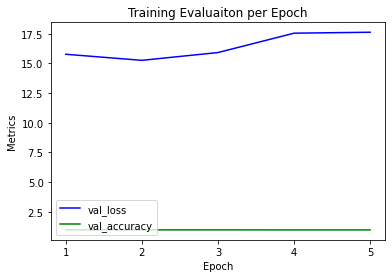

In [ ]:
plot_training(epochs_val_loss, epochs_accuracy, N_EPOCHS)

### Content-Based Recommender

In [ ]:
# Remove User and Ratings for Content Based Similarity Recommender
drop_cols = ['User','LIKE_ARTIST']
artists_df = df.groupby('Artist').mean()
artists_df.drop(columns=drop_cols, inplace=True)

artists_df.sample(2)


,Edgy,Thoughtful,Youthful,Current,Stylish,Beautiful,Fun,Authentic,Credible,Cool,Catchy,Passionate,Timeless,Original,Talented,Distinctive,Approachable,Trendsetter,Upbeat,Energetic,None of these,Sexy,Dated,Warm
Artist,,,,,,,,,,,,,,,,,,,,,,,,
26,0.218182,0.100000,0.163636,0.136364,0.127273,0.200000,0.290909,0.200000,0.236364,0.236364,0.318182,0.136364,0.181818,0.327273,0.281818,0.372727,0.109091,0.072727,0.163636,0.263636,0.018182,0.072727,0.036364,0.109091
42,0.372737,0.030884,0.095847,0.040469,0.041534,0.024494,0.129925,0.188498,0.097977,0.125666,0.179979,0.132055,0.161874,0.269436,0.080937,0.390841,0.011715,0.134185,0.062833,0.410011,0.034079,0.020234,0.194888,0.003195


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute how similar two artists are using defined artists features.
cosine_sim = cosine_similarity(artists_df)

# Compute similarity using the trained model Artist Embedding tensor.
for name, param in model.named_parameters():                
    if name.startswith('artist'):
      artist_embedding = param.detach().numpy()
      artist_embedding_similarity = cosine_similarity(artist_embedding)

## Step 4: Model Evaluation

In [ ]:
# Load best trained model hosted on github, in place updates given `model`.
# model.load_state_dict(torch.load(MODEL_PATH))
# Conpute loss and accuracy of test set
eval_epoch(model,  test_dataloader, criterion)

(17.360063358586658, 0.9792917166866747)

Content based recommendationc code taken from [Recommender Systems in Python: Beginner Tutorial By Rounak Banik](https://www.datacamp.com/community/tutorials/recommender-systems-python).

In [ ]:
def artist_seen(user,artist):
  user_df = df[df.User == user]
  return artist in user_df['Artist']

def content_based_recommendation(user, similarity, top=TOP):
  """
    Get top similar artists for given artisst id. 
  """

  # Get user's favorite artist
  user_df = df[df.User == user]
  max_rating_idx = user_df['LIKE_ARTIST'].idxmax()
  artist = df['Artist'].iat[max_rating_idx]

  # Get pairwsie similarity scores of all artist with one artist.
  sim_scores = list(enumerate(similarity[artist]))

  # Sort based on similarity scores.
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Get top most similar artists. 
  most_similar = sim_scores[1:1+top]

  # Get corresponding artists indices
  artists = [i[0] for i in most_similar]

  return artists

def collaborative_filtering_recommendation(user, model, n_artists, top=TOP):
  model.eval()
  top_ratings = []
  user = torch.LongTensor([user])

  # Check top ratings of user among all artists
  for artist in range(n_artists):
    if not artist_seen(user.item(),artist):
      artist = torch.LongTensor([artist])
      top_ratings.append((artist.item(), model(user, artist).item()))
  highest_ranking = sorted(top_ratings, key=lambda x: x[1], reverse=True)[:top]
  artists = [i[0] for i in highest_ranking]

  return artists



Seen artists: [22] 

Content Based Top artists for user 9582: [7, 39, 23, 3, 6]

Content Based Artist Embedding Top artists for user 9582: [21, 9, 29, 23, 39]

Collaborative Filtering Top artists for user 9582: [7, 43, 8, 4, 25]


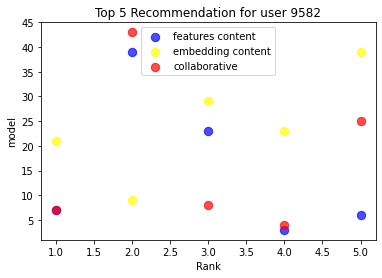

In [ ]:
user = 9582
seen_artists = list(df[df.User == user]['Artist'])
print("Seen artists:",seen_artists,'\n')
content_rec = content_based_recommendation(user, cosine_sim)
print("Content Based Top artists for user {}: {}\n".format(user, content_rec))

content_rec_artist_embedding = content_based_recommendation(user, artist_embedding_similarity)
print("Content Based Artist Embedding Top artists for user {}: {}\n".format(user, content_rec_artist_embedding))

collab_rec = collaborative_filtering_recommendation(user, model, n_artists)
print("Collaborative Filtering Top artists for user {}: {}".format(user, collab_rec))

plot_results(content_rec, content_rec_artist_embedding, collab_rec, user, TOP)


Seen artists: [33] 

Content Based Top artists for user 12525: [2, 10, 11, 37, 47]

Content Based Artist Embedding Top artists for user 12525: [7, 17, 24, 39, 40]

Collaborative Filtering Top artists for user 12525: [7, 25, 27, 40, 43]


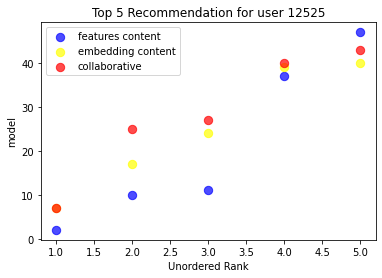

In [ ]:
user = 12525

print("Seen artists:",list(df[df.User == user]['Artist']),'\n')
content_rec = content_based_recommendation(user, cosine_sim)
print("Content Based Top artists for user {}: {}\n".format(user, sorted(content_rec)))

content_rec_artist_embedding = content_based_recommendation(user, artist_embedding_similarity)
print("Content Based Artist Embedding Top artists for user {}: {}\n".format(user, sorted(content_rec_artist_embedding)))

collab_rec = collaborative_filtering_recommendation(user, model, n_artists)
print("Collaborative Filtering Top artists for user {}: {}".format(user, sorted(collab_rec)))

plot_results(content_rec, content_rec_artist_embedding, collab_rec, user, TOP)



Seen artists: [32] 

Content Based Top artists for user 12531: [36, 10, 38, 8, 12]

Content Based Artist Embedding Top artists for user 12531: [25, 37, 38, 48, 34]

Collaborative Filtering Top artists for user 12531: [19, 44, 43, 24, 48]


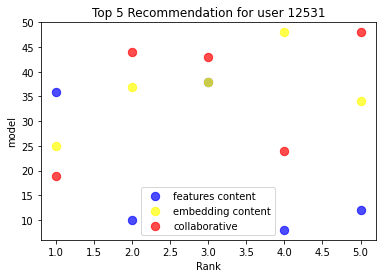

In [ ]:
user = 12531

print("Seen artists:",list(df[df.User == user]['Artist']),'\n')
content_rec = content_based_recommendation(user, cosine_sim)
print("Content Based Top artists for user {}: {}\n".format(user, content_rec))

content_rec_artist_embedding = content_based_recommendation(user, artist_embedding_similarity)
print("Content Based Artist Embedding Top artists for user {}: {}\n".format(user, content_rec_artist_embedding))

collab_rec = collaborative_filtering_recommendation(user, model, n_artists)
print("Collaborative Filtering Top artists for user {}: {}".format(user, collab_rec))

plot_results(content_rec, content_rec_artist_embedding, collab_rec, user, TOP)